In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0    914      0 --:--:-- --:--:-- --:--:--   911
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


## Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

# IMDB rating classification 

## Dataset

The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.


In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
df["text"][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

In [0]:
data_lm.save()

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl')]

In [0]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [0]:
data = TextClasDataBunch.from_csv(path, "texts.csv")

In [0]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative


### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

In [0]:
data.train_ds[0][0]

Text xxbos i have never posted a review before , but i had to do it for this film ! xxmaj this film is xxup so bad , i found myself trying to justify how bad it is by trying to think of it as xxunk or parody . xxmaj but it xxup xxunk xxmaj it is truly , un - self - xxunk xxup bad . xxmaj this is a serious attempt that xxunk gloriously . xxmaj other reviewers have pointed out the film 's many flaws , so i 'll try not to repeat these , but i do urge you to see this film . xxmaj throughout it i was either xxunk , literally xxunk with disbelief , or rolling on the floor in xxunk . i have n't had so much fun watching a film in years . xxmaj in fact , i 'm going to try to get all my friends to see it because it 's the kind of movie that needs to be shared . 
 
  xxmaj my favorite parts : -- xxmaj when xxmaj arthur xxunk to be a go - go boy ( his dancing is unbelievable ) -- xxmaj the gratuitous nudity ( the director / leading actor just had to get a nude shot in ) -- xxmaj the preacher 's of

In [0]:
data.train_ds[0][0].data[:10]

array([   2,   18,   41,  121, 6020,   12,  566,  166,   10,   30])

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Build Language model

In [0]:
# batch size
bs = 24 

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup')]

In [0]:
(path/'train').ls()

[PosixPath('/content/data/imdb/train/pos'),
 PosixPath('/content/data/imdb/train/unsupBow.feat'),
 PosixPath('/content/data/imdb/train/labeledBow.feat'),
 PosixPath('/content/data/imdb/train/neg')]

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,"playing an actual role ... a task made easier because he 's playing himself in a fictional story that gives him a chance to croon a few numbers . \n \n xxmaj sinatra 's entrance is quite funny . xxmaj michele xxmaj morgan hears a knock at the door , and asks who 's there . xxmaj from outside , a xxmaj hoboken - toned voice answers ' xxmaj"
1,"surface some odd recollections . xxmaj memory - narrative , xxmaj resnais creates . \n \n --polarisdib xxbos xxmaj on this 4th of xxmaj july weekend it 's heartening to see the spirit of the xxmaj declaration of xxmaj independence alive and well in the film "" xxmaj war , xxmaj inc. "" xxmaj just as our founding fathers gave the back of their collective hand to xxmaj king"
2,"sweetheart of xxmaj jenny , xxmaj professor xxmaj bedlam ( xxmaj eddie xxmaj izzard ) , proposes xxmaj matt to lure xxmaj jenny to strip her superpowers . \n \n "" xxmaj my xxmaj super xxmaj ex - xxmaj girlfriend "" is delightfully silly and funny . xxmaj this romantic comedy - adventure has many hilarious moments and is very entertaining . xxmaj luke xxmaj wilson is great in"
3,"father , about his two sons , and about their destinies . xxmaj with shocking twist after shocking twist , this film never allows for a lull in the plot . xxmaj bill xxmaj paxton plays the father , but the most notable performances are that of his older son , xxmaj fenton , played by xxmaj matthew o'leary and his younger son , xxmaj adam , played by xxmaj"
4,"facts and figures , and always wanted things to be seen as they were so i would like to believe he had something to do with that . \n \n xxmaj he currently lives in xxmaj okinawa , xxmaj japan , married to my mother for over 40 years ( ironically , she 's xxmaj japanese ) , and a few years ago was awarded one of the highest"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


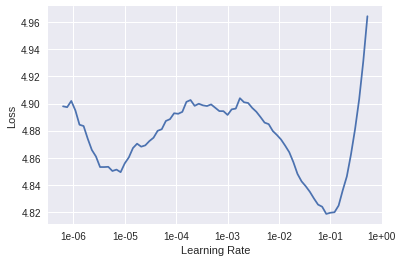

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.231979,4.055971,0.293152,1:29:53


In [0]:
learn.save("stage-1")

In [0]:
learn.load("stage-1")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj in xxmaj frank xxmaj sinatra 's first three films , he was purely a speciality act : ostensibly playing himself , he merely shows up to croon a song during a nightclub sequence in somebody else 's movie . xxmaj in his fourth film , the very enjoyable ' xxmaj higher and xxmaj higher ' , xxmaj young xxmaj blue xxmaj eyes transitions into an acting career by playing an actual role ... a task made easier because he 's playing himself in a fictional story that gives him a chance to croon a few numbers . 
 
  xxmaj sinatra 's entrance is quite funny . xxmaj michele xxmaj morgan hears a knock at the door , and asks who 's there . xxmaj from outside , a xxmaj hoboken - toned voice answers ' xxmaj frank xxmaj sinatra ' . xxmaj sure enough ... 
 
  xxmaj the opening credits of ' xxmaj higher and xxmaj higher ' may confuse some viewers , as the names of songwriters xxmaj rodgers and xxmaj hart are prom

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


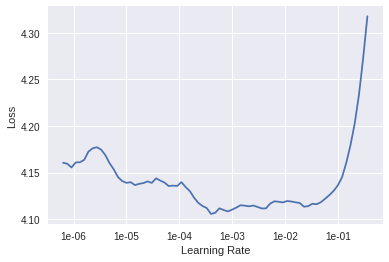

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.965311,3.881896,0.310600,1:40:03
1,3.866650,3.813432,0.320197,1:40:34


Buffered data was truncated after reaching the output size limit.

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because other people have so much time to watch this movie . It is the bank must , a movie that really is as much woman as it is . It 's really bad . Those are really
I liked this movie because of the so - problem " Hell of the Art " film . The script is star and the throughout is the book ) . There are some people who up n't get the genre from


In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


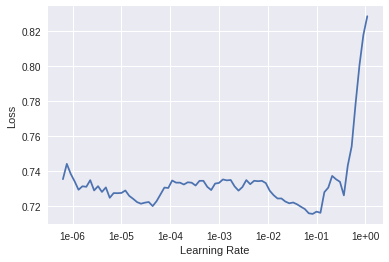

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.644196,0.580581,0.699680,19:33


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.542609,0.462108,0.780960,23:08


In [0]:
learn.save('second')

In [0]:
learn.load("second")

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.459503,0.394029,0.823600,28:59


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.412757,0.353450,0.845360,36:03
1,0.412689,0.357569,0.844800,35:24


In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0018, 0.9982]))

(Category pos, tensor(1), tensor([0.0018, 0.9982]))